In [1]:
import numpy as np
import pandas as pd
import pickle
import random
import matplotlib.pyplot as plt

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### loading the data and other specifcs

In [19]:
best_model_path = '../../tr_models/classifierX3_best.pth'
last_model_path = '../../tr_models/classifierX3_last.pth'
plot_vals_path = '../../outputs/classifierX3_plotres.pkl'

tr_labels = pd.read_csv('../../data/small_ntu_frames/train_labels', header=None)
v_labels = pd.read_csv('../../data/small_ntu_frames/val_labels', header=None)

with open('../../data/mini_ntu_frames/mini_train_data.pkl', 'rb') as f:
    tr_dict = pickle.load(f)
with open('../../data/mini_ntu_frames/mini_val_data.pkl', 'rb') as f:
    v_dict = pickle.load(f)

### preprocessing and other stuff

In [3]:
def flatten_frames(arr_3d):
    n_frames = arr_3d.shape[0]
    temp_arr = np.zeros((n_frames, 48))
    for i in range(n_frames):
        arr_3d[i, :, :] = arr_3d[i, :, :] - arr_3d[i, 7, :]
        norz = np.linalg.norm(arr_3d[1, 6, :] - arr_3d[i, 7, :])
        arr_3d[i, :, :] /= 1.0*norz
        temp_arr[i, :] = np.reshape(arr_3d[i, :, :], (1, -1))
    return temp_arr

def flatten_dict(d_dict):
    for i in d_dict:
        d_dict[i] = flatten_frames(d_dict[i])
    return d_dict

In [4]:
tr_d = flatten_dict(tr_dict)
v_d = flatten_dict(v_dict)

In [6]:
def data_gen(d_dict, d_labels):
    while(True):
        d_id = random.sample(list(d_dict), 1)[0]
        databatch = d_dict[d_id]
        if 'train' in d_id:
            idx = int(d_id.replace('train', ''))
            label = d_labels.iloc[idx, 1]
        elif 'val' in d_id:
            idx = int(d_id.replace('val', ''))
            label = d_labels.iloc[idx, 1]
        yield databatch,label

In [7]:
def val_data_gen(d_dict, d_labels):
    counter = 0
    n_s = len(d_dict)
    while(counter<n_s):
        d_id = list(d_dict)[counter]
        databatch = d_dict[d_id]
        if 'val' in d_id:
            idx = int(d_id.replace('val', ''))
            label = d_labels.iloc[idx, 1]
        counter += 1
        counter = counter % n_s
        yield databatch,label

In [8]:
Dtr = data_gen(tr_d, tr_labels)
Dv = data_gen(v_d, v_labels)

### The classifier

In [10]:
#action LSTM
class LSTMClassifier(nn.Module):
    def __init__(self, joints_dim, hidden_dim, label_size, batch_size, num_layers, kernel_size):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
        joints_dim2d = joints_dim - 16
        
        self.lstm3 = nn.LSTM(joints_dim, hidden_dim, num_layers=self.num_layers)
        self.conv1_3 = nn.Conv1d(1, 1, kernel_size, stride=1, padding=1)
        
        self.lstm2_1 = nn.LSTM(joints_dim2d, hidden_dim, num_layers=self.num_layers)
        self.conv1_2_1 = nn.Conv1d(1, 1, kernel_size, stride=1, padding=1)
        self.lstm2_2 = nn.LSTM(joints_dim2d, hidden_dim, num_layers=self.num_layers)
        self.conv1_2_2 = nn.Conv1d(1, 1, kernel_size, stride=1, padding=1)
        self.lstm2_3 = nn.LSTM(joints_dim2d, hidden_dim, num_layers=self.num_layers)
        self.conv1_2_3 = nn.Conv1d(1, 1, kernel_size, stride=1, padding=1)
        
#         self.conv1_1 = nn.Conv1d(4, 2, kernel_size, stride=1, padding=1) #for kernel size=3
#         self.conv1_2 = nn.Conv1d(2, 1, kernel_size, stride=1, padding=1) #for kernel size=3
        
        self.hidden3 = self.init_hidden3()
        self.hidden2_1 = self.init_hidden2_1()
        self.hidden2_2 = self.init_hidden2_2()
        self.hidden2_3 = self.init_hidden2_3()
        
        self.hidden2label = nn.Linear(hidden_dim, label_size)
    
    def init_hidden3(self):
        # the first is the hidden h
        # the second is the cell  c
        return (autograd.Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).cuda()),
                autograd.Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).cuda()))
    def init_hidden2_1(self):
        # the first is the hidden h
        # the second is the cell  c
        return (autograd.Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).cuda()),
                autograd.Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).cuda()))
    def init_hidden2_2(self):
        # the first is the hidden h
        # the second is the cell  c
        return (autograd.Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).cuda()),
                autograd.Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).cuda()))
    def init_hidden2_3(self):
        # the first is the hidden h
        # the second is the cell  c
        return (autograd.Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).cuda()),
                autograd.Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).cuda()))
    
    
    def forward(self, joints3d_vec):
        x3 = joints3d_vec
        x2 = x3.view(-1, 16, 3)
        x2_1 = x2[:,:,1:3].contiguous().view(-1, 1, 32)
        x2_2 = x2[:,:,0:2].contiguous().view(-1, 1, 32)
        x2_3 = x2[:,:,[0,2]].contiguous().view(-1, 1, 32)
        
        lstm_out3, self.hidden3 = self.lstm3(x3, self.hidden3)
        lstm_out2_1, self.hidden2_1 = self.lstm2_1(x2_1, self.hidden2_1)
        lstm_out2_2, self.hidden2_2 = self.lstm2_2(x2_2, self.hidden2_2)
        lstm_out2_3, self.hidden2_3 = self.lstm2_3(x2_3, self.hidden2_3)
        
        t3 = lstm_out3[-1].view(self.batch_size,1,-1)
        t2_1 = lstm_out2_1[-1].view(self.batch_size,1,-1)
        t2_2 = lstm_out2_2[-1].view(self.batch_size,1,-1)
        t2_3 = lstm_out2_3[-1].view(self.batch_size,1,-1)

        y3 = self.conv1_3(t3)
        y2_1 = self.conv1_2_1(t2_1)
        y2_2 = self.conv1_2_2(t2_2)
        y2_3 = self.conv1_2_3(t2_3)
        
        y3 += y2_1+y2_2+y2_3
        
        y3 = y3.contiguous().view(-1, self.hidden_dim)        
        y  = self.hidden2label(y3)
        
        log_probs = F.softmax(y, dim=1)
        return log_probs
#instanstiating a model
model0 = LSTMClassifier(48, 512, 8, 1, 2, 3)
#to do stuff in CUDA
model0 = model0.cuda()

### evaluation function

In [11]:
Dv1 = val_data_gen(v_d, v_labels)
n_sv = len(v_d)
def eval_model(model):
    right_count = 0
    for i in range(n_sv):
        X, Y = next(Dv1)
        X = autograd.Variable(torch.from_numpy(X).float()).cuda()
        X1 = X.view(len(X), 1, -1)
        y_hat = model(X1)
        y_pred = np.argmax(y_hat.data.cpu().numpy())
        if y_pred*6 == Y:
            right_count += 1
    acc = right_count*100.0/n_sv
    return acc

### training function 

In [20]:
def save_model(model, m):
    if m == 'last':
        torch.save(model.state_dict(), last_model_path)
        print('saved last model at {}'.format(last_model_path))
    elif m == 'best':
        torch.save(model.state_dict(), best_model_path)
        print('saved best model at {}'.format(best_model_path))

#training function
def train(model, num_epoch, num_iter, rec_interval, disp_interval):
    optimizer = optim.Adam(model.parameters(), lr = 6e-5)
    loss_values = []
    avg_loss_values = []
    rec_step = 0
    criterion = nn.CrossEntropyLoss()
    acc_values = []
    last_acc = 0
    print('Starting the training ...')
    for eph in range(num_epoch):
        print('epoch {} starting ...'.format(eph))
        avg_loss = 0
        n_samples = 0
        for i in range(num_iter):
            model.hidden3 = (model.hidden3[0].detach(), model.hidden3[1].detach())
            model.hidden2_1 = (model.hidden2_1[0].detach(), model.hidden2_1[1].detach())
            model.hidden2_2 = (model.hidden2_2[0].detach(), model.hidden2_2[1].detach())
            model.hidden2_3 = (model.hidden2_3[0].detach(), model.hidden2_3[1].detach())
            model.zero_grad()
            X,Y = next(Dtr)
            n_samples += len(X)
            X = autograd.Variable(torch.from_numpy(X).float()).cuda()
            X1 = X.view(len(X), 1, -1)
            Y = autograd.Variable(torch.LongTensor(np.array([Y/6]))).cuda() #divide by 6 because all labels are multiple of 6

            y_hat = model(X1)
            loss = criterion(y_hat, Y)
            avg_loss += loss.data[0]
            
            if i % disp_interval == 0:
                print('epoch: %d iterations: %d loss :%g' % (eph, i, loss.data[0]))
            if rec_step%rec_interval==0:
                loss_values.append(loss.data[0])
            
            loss.backward()     
            optimizer.step()
            rec_step += 1
            
        avg_loss /= n_samples
        avg_loss_values.append(avg_loss)
        # evaluating model accuracy
        acc = eval_model(model)
        acc_values.append(acc)
        # saving the best and last train models
        save_model(model, 'last')
        if acc >= last_acc:
            save_model(model, 'best')
        else:
            pass
        print('epoch: {} <====train track===> avg_loss: {}, accuracy: {}%\n'.format(eph, avg_loss, acc))
        f = open(plot_vals_path, 'wb')
        pickle.dump((loss_vals, avg_loss_vals, acc_values), f)
        f.close()
    return loss_values, avg_loss_values, acc_values

Starting the training ...
epoch 0 starting ...
epoch: 0 iterations: 0 loss :1.27401
epoch: 0 iterations: 10 loss :1.27401
epoch: 0 iterations: 20 loss :1.27401
epoch: 0 iterations: 30 loss :1.27401
epoch: 0 iterations: 40 loss :1.27401
epoch: 0 iterations: 50 loss :1.27401
epoch: 0 iterations: 60 loss :1.27401
epoch: 0 iterations: 70 loss :1.27401
epoch: 0 iterations: 80 loss :1.27401
epoch: 0 iterations: 90 loss :1.27401
saved last model at ../../tr_models/classifierX3_last.pth
saved best model at ../../tr_models/classifierX3_best.pth
epoch: 0 <====train track===> avg_loss: 0.01592311899656952, accuracy: 66.66666666666667%

epoch 1 starting ...
epoch: 1 iterations: 0 loss :1.27401
epoch: 1 iterations: 10 loss :1.27401
epoch: 1 iterations: 20 loss :1.27401
epoch: 1 iterations: 30 loss :1.27401
epoch: 1 iterations: 40 loss :1.27401
epoch: 1 iterations: 50 loss :1.27401
epoch: 1 iterations: 60 loss :1.27401
epoch: 1 iterations: 70 loss :1.27401
epoch: 1 iterations: 80 loss :1.27401
epoch

Text(0,0.5,'avg loss')

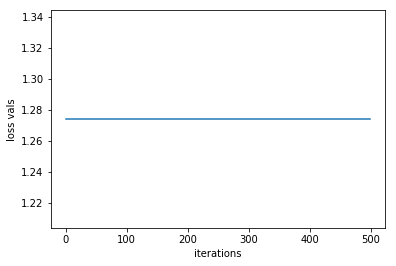

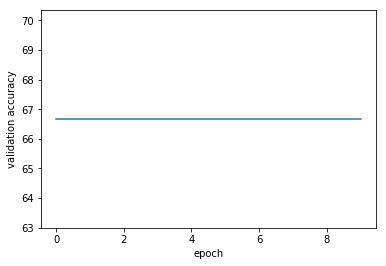

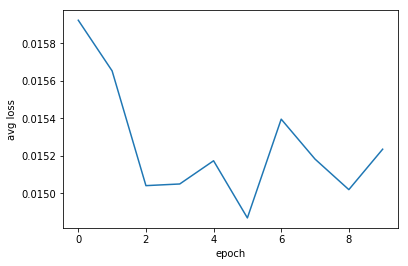

In [21]:
loss_vals, avg_loss_vals, acc_values = train(model0, 10, 100, 2, 10) #100eph_8e-6, 
plt.figure()
plt.plot(loss_vals)
plt.xlabel('iterations')
plt.ylabel('loss vals')
plt.figure()
plt.plot(acc_values)
plt.xlabel('epoch')
plt.ylabel('validation accuracy')
plt.figure()
plt.plot(avg_loss_vals)
plt.xlabel('epoch')
plt.ylabel('avg loss')